In [2]:
# Import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from datasets import load_dataset
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import glob
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from tqdm.auto import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import face_recognition
import os
import random
from matplotlib.colors import LinearSegmentedColormap

In [3]:
# Define the number of epochs
num_epochs = 10

# Define the batch size
batch_size = 16

# Define the input shape
input_shape = (224, 224)

In [4]:
class AffectNetHqDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
def heatmap_generator(image):
    face_locations = face_recognition.face_locations(image)

    # Load the pre-trained facial landmark model
    face_landmarks_list = face_recognition.face_landmarks(image, face_locations)

    h,w = image.shape[:2]
    lm = np.zeros([h,w])

    # Draw facial landmarks on the image
    for face_landmarks in face_landmarks_list:
        for landmark_type, landmarks in face_landmarks.items():
            for (x, y) in landmarks:
                if x < h and y < w :
                    lm[y,x] = 1

    heatmap = cv2.GaussianBlur(lm, [59,59], 3)         

    return heatmap

In [6]:
import torch
import torch.nn as nn

class PrivilegedAttributionLoss(nn.Module):
    def __init__(self):
        super(PrivilegedAttributionLoss, self).__init__()

    def forward(self, attribution_maps, prior_maps):
        # Add a small value to standard deviation to avoid division by zero
        epsilon = 1e-8

        # Calculate mean and standard deviation for each sample in the batch
        mean_al = torch.mean(attribution_maps, dim=[1, 2, 3], keepdim=True)  # Assuming BCHW format
        std_al = torch.std(attribution_maps, dim=[1, 2, 3], keepdim=True) + epsilon

        # Calculate the PAL loss
        # Ensure that the broadcasting in the subtraction and division is correct
        pal_loss = -torch.sum((attribution_maps - mean_al) / std_al * prior_maps, dim=[1, 2, 3])

        # Return the mean loss over the batch
        return torch.mean(pal_loss)


In [7]:
# Load the full dataset
full_dataset = load_dataset("Piro17/affectnethq", split='train')

# Split the dataset into train and test subsets
train_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_subset, test_subset = random_split(full_dataset, [train_size, test_size])

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation((-10, 10)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create the dataset and dataloader using the subsets
train_dataset = AffectNetHqDataset(Subset(full_dataset, train_subset.indices), transform=train_transform)
test_dataset = AffectNetHqDataset(Subset(full_dataset, test_subset.indices), transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [8]:
import torchvision
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim

# Charger le modèle pré-entraîné ResNet50
base_model = torchvision.models.resnet50(pretrained=True)

# Supprimer la dernière couche entièrement connectée (fc)
base_model = nn.Sequential(*list(base_model.children())[:-1])

# Ajouter une nouvelle couche adaptée à 7 classes
num_classes = 7
classifier_layer = nn.Linear(2048, num_classes)  # ResNet50 utilise 2048 features avant la couche fc
model = nn.Sequential(base_model, nn.Flatten(), classifier_layer)

# Afficher la structure du modèle
summary(model, (3, 224, 224))  # Assurez-vous d'ajuster les dimensions en fonction de vos données

# Identifier la dernière couche de convolution
# Pour ResNet50, la dernière couche de convolution est la dernière couche de la partie 'base_model'
# Identifier la dernière couche de convolution dans ResNet50
# Notez que dans ResNet50, la dernière couche de convolution se trouve dans la dernière "Bottleneck"
last_conv_layer = list(base_model.children())[-3][2].conv3
print("last conv layer =", last_conv_layer)

# Définir l'optimiseur
optimizer = optim.Adam(model.parameters(), lr=4e-5)


/opt/homebrew/Caskroom/mambaforge/base/envs/ros_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/ros_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

  0%|          | 0/348 [00:00<?, ?it/s]

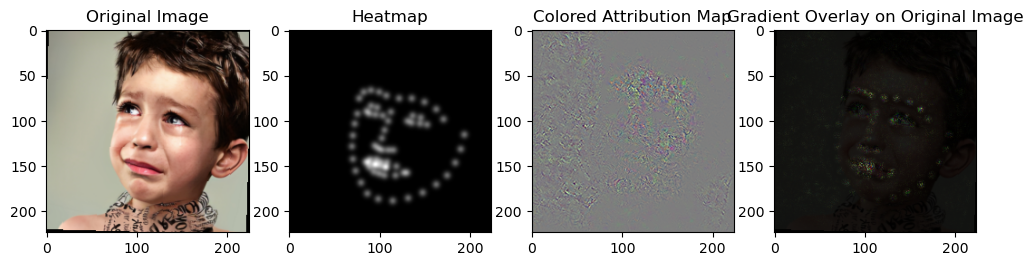

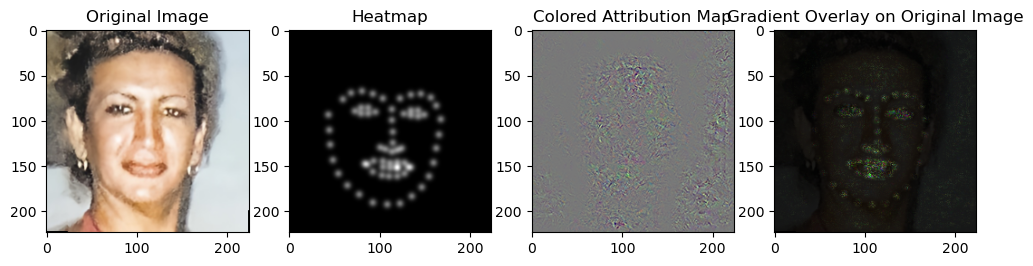

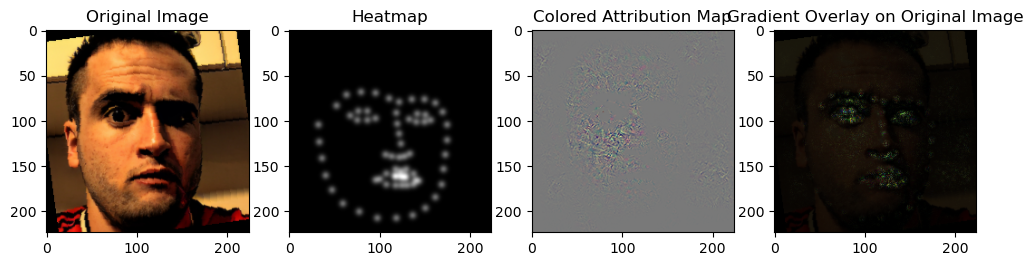

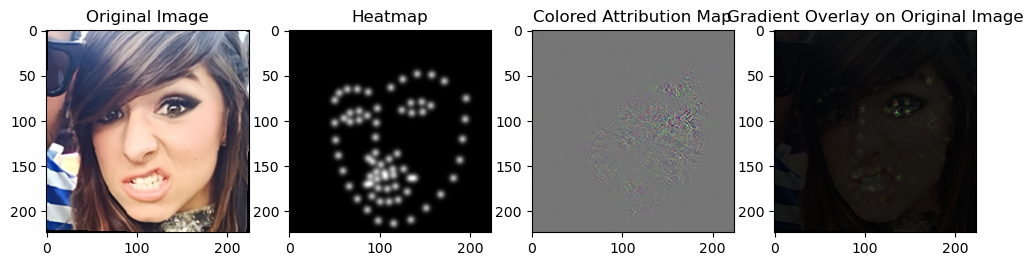

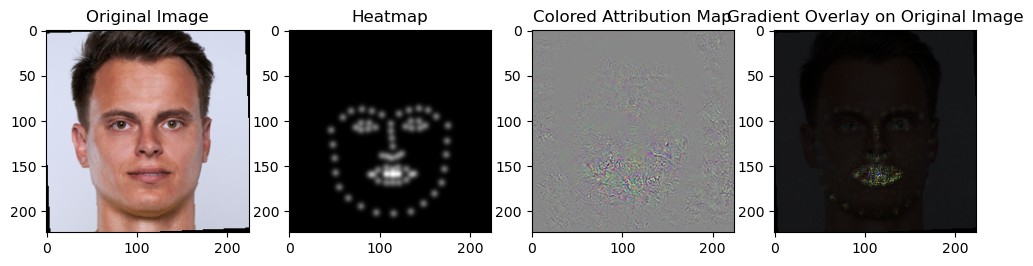

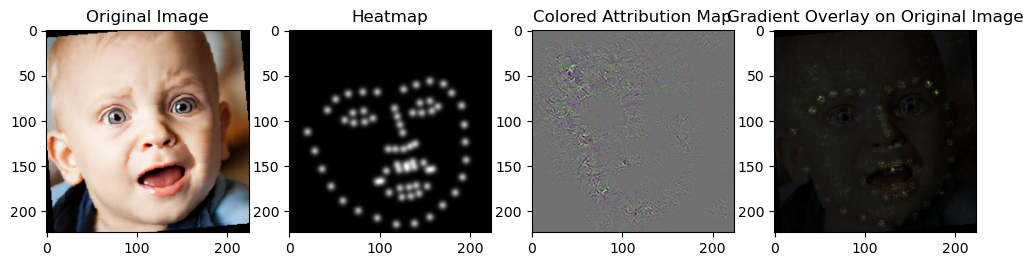

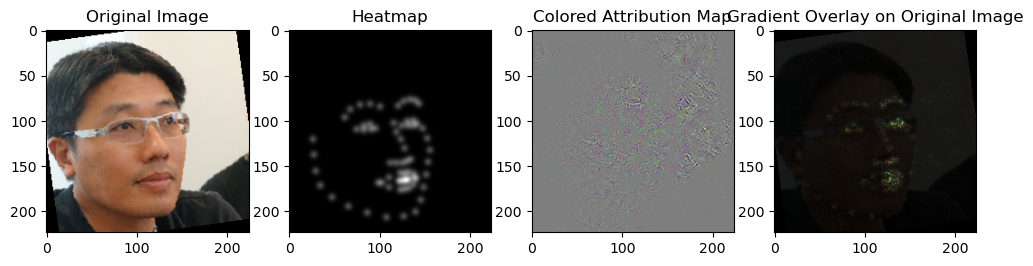

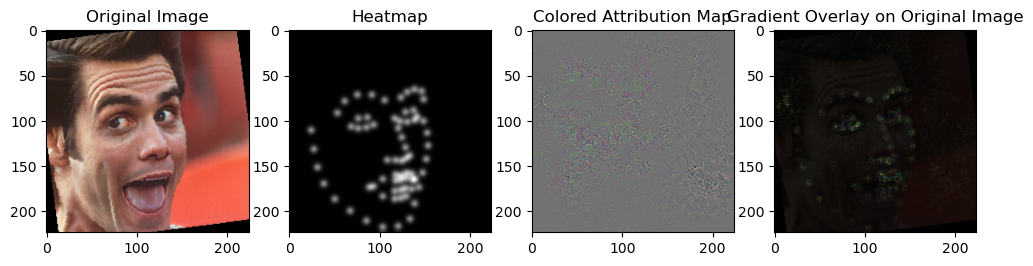

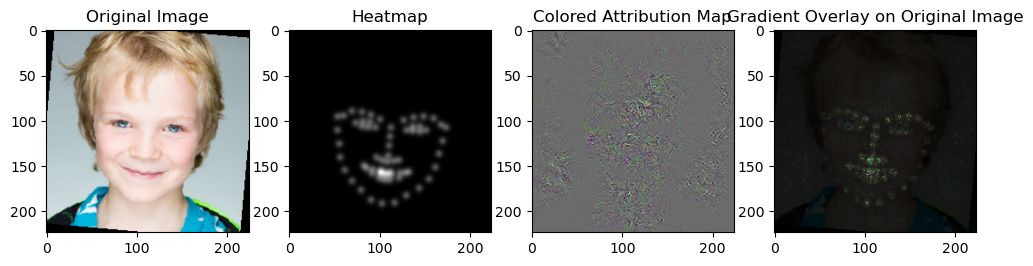

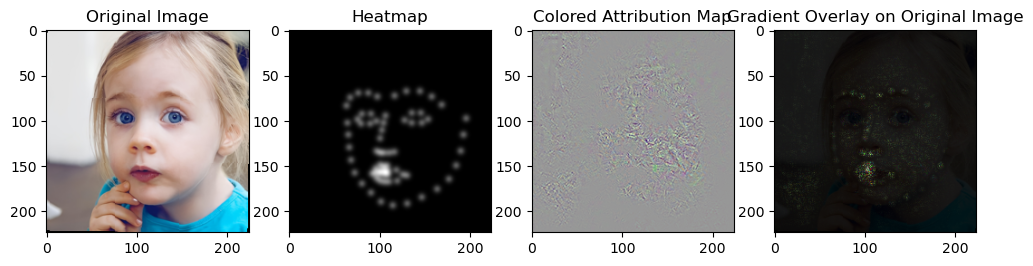

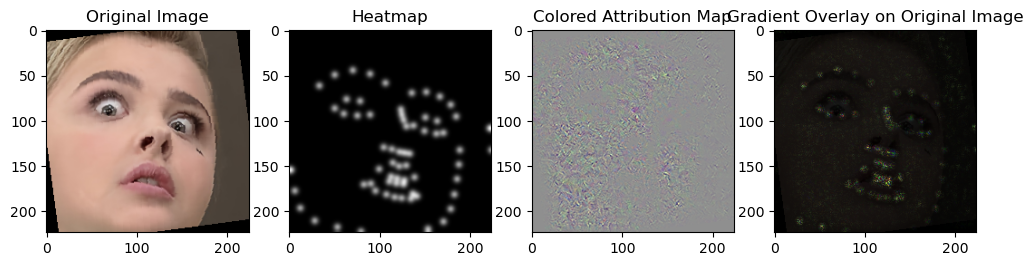

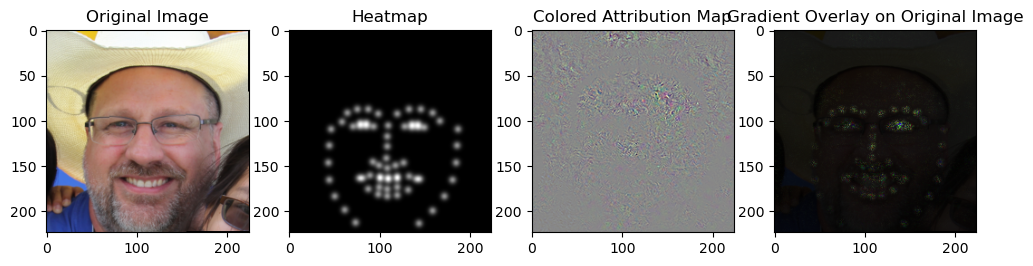

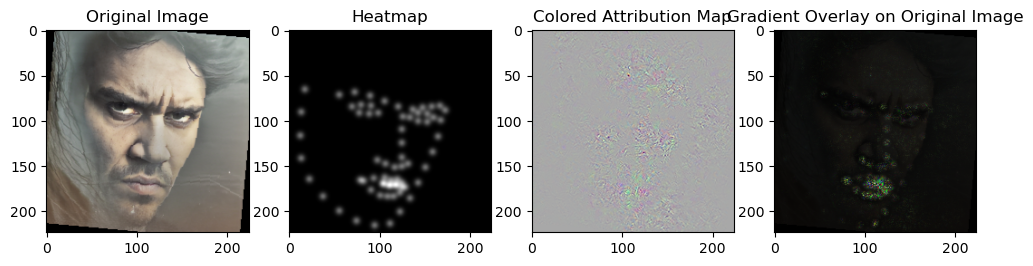

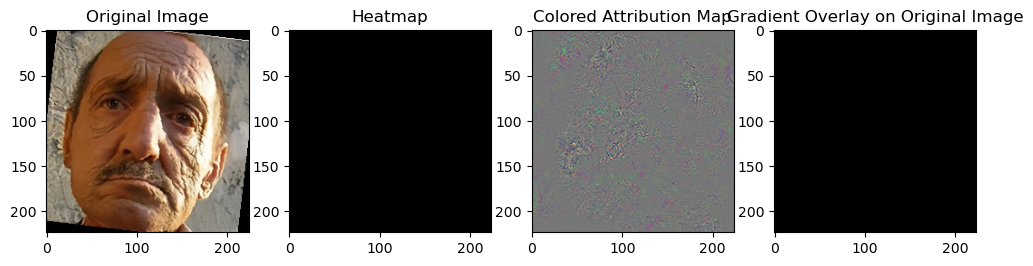

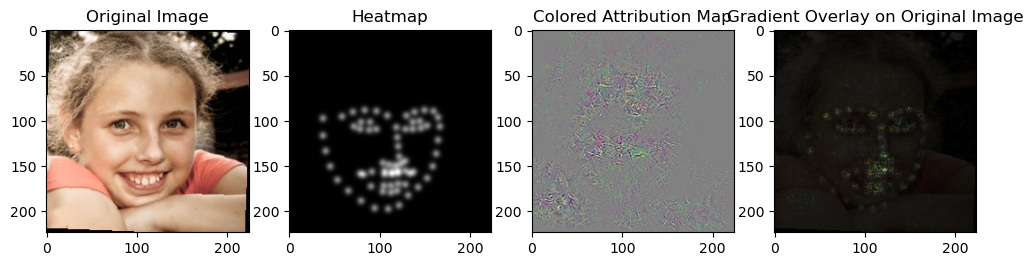

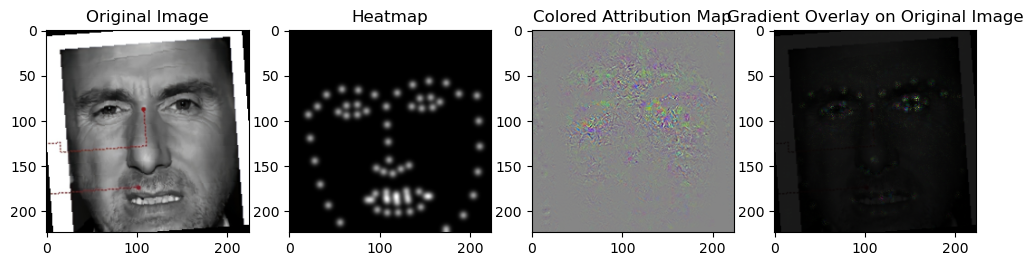

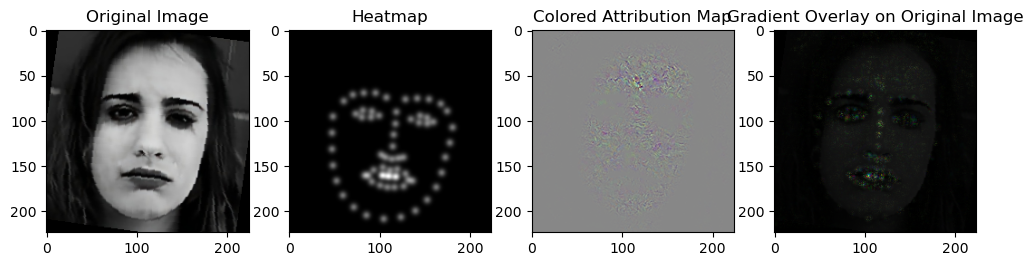

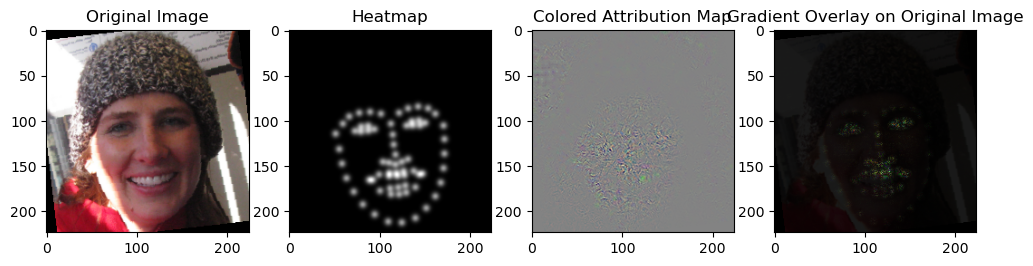

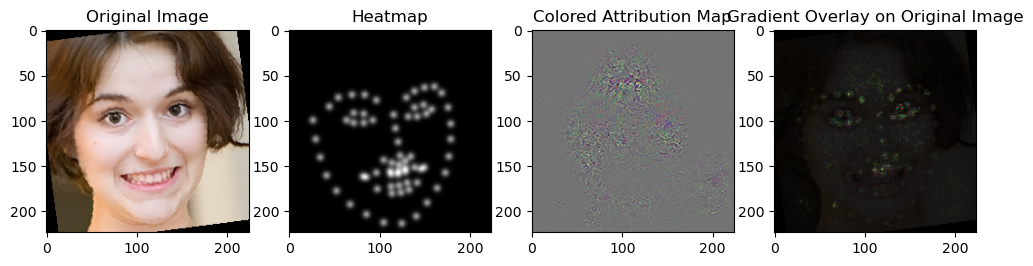

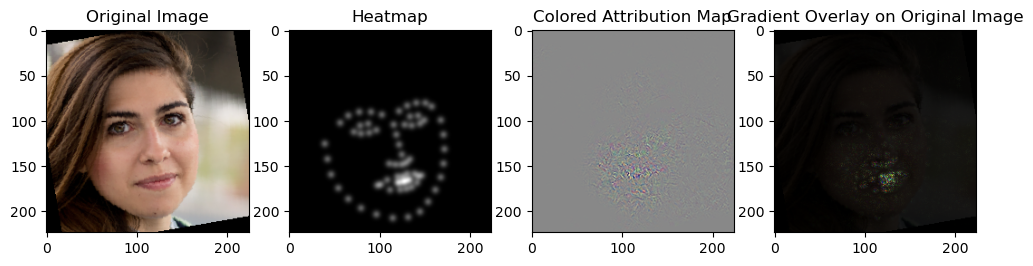

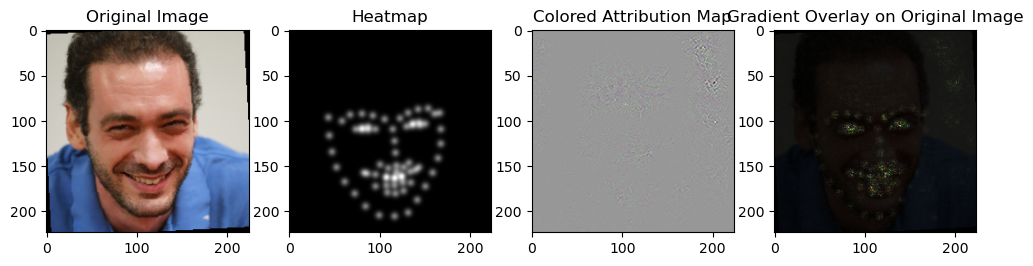

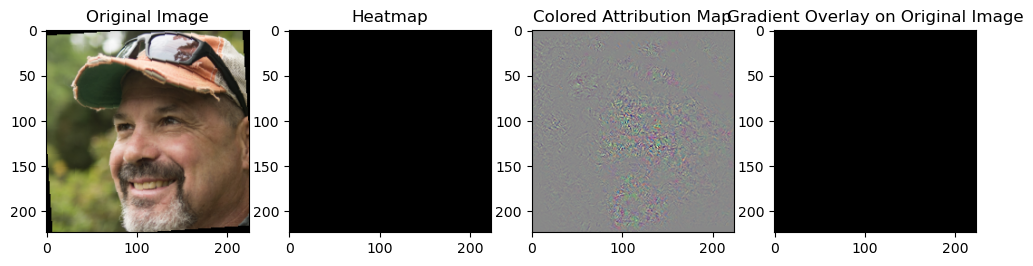

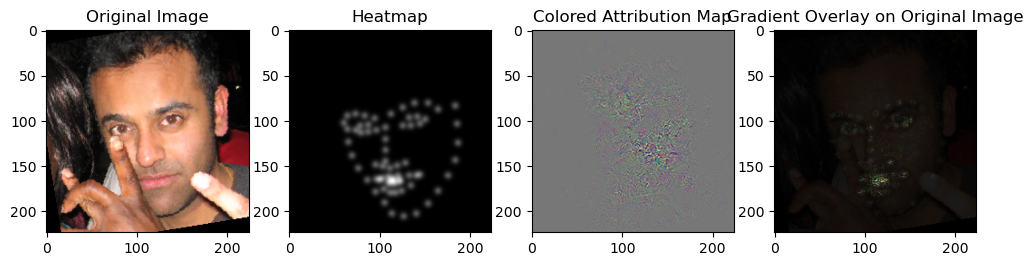

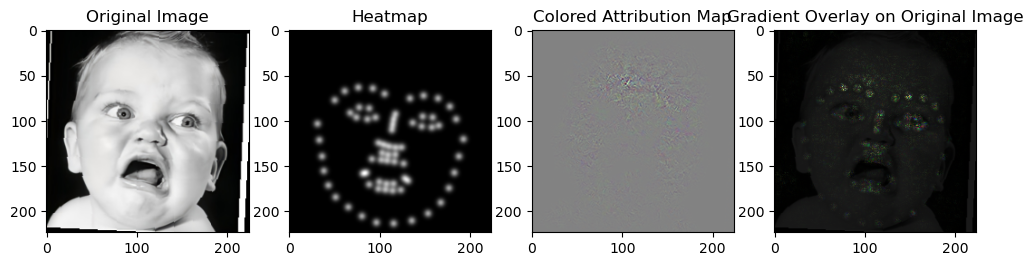

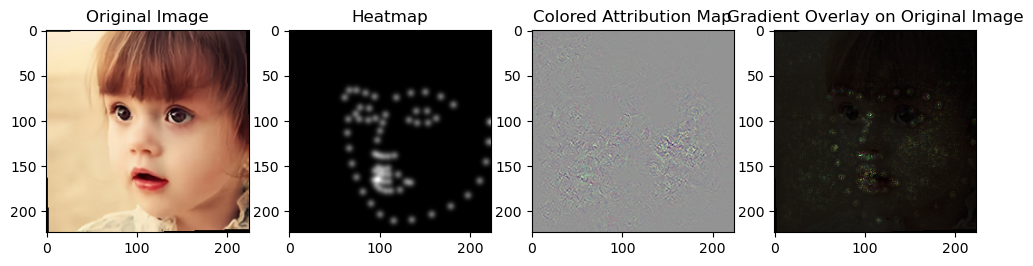

KeyboardInterrupt: 

In [37]:
from matplotlib.colors import LinearSegmentedColormap

num_epochs = 10
criterion = torch.nn.CrossEntropyLoss()
loss_values = [] 
accuracy_values = []  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_pal_loss = 0.0
    running_corrects = 0.0
    total_samples = 0.0
    for images, labels in tqdm(train_loader):
        # Initialiser un tenseur pour stocker toutes les heatmaps
        batch_heatmaps = torch.zeros_like(images)

        for i in range(images.size(0)):
            # Convertir le tenseur PyTorch en tableau NumPy pour l'image i
            image_np = images[i].permute(1, 2, 0).cpu().detach().numpy()
            image_np = (image_np * 255).astype(np.uint8) if image_np.dtype != np.uint8 else image_np
            image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

            # Générer la heatmap pour l'image actuelle
            heatmap_np = heatmap_generator(image_np)
            heatmap_tensor = torch.from_numpy(heatmap_np).float().unsqueeze(0)

            # Normaliser la heatmap et l'adapter à la taille de l'image
            heatmap_tensor = heatmap_tensor / torch.max(heatmap_tensor)
            heatmap_tensor = heatmap_tensor.repeat(3, 1, 1)

            # Stocker la heatmap dans le tenseur batch
            batch_heatmaps[i] = heatmap_tensor

        # Ensure that images require gradients
        images.requires_grad_()

        # Forward pass
        outputs = model(images)
        labels = labels.long()

        # Calcul de la classification loss
        classification_loss = criterion(outputs, labels)

        # Backward pass for gradients with respect to the input images
        classification_loss.backward(retain_graph=True)  
        gradients = images.grad

        # Compute the attribution maps as the element-wise product of the gradients and the input images
        attribution_maps = gradients * images

        # Compute the PAL loss using the attribution maps and the prior maps
        pal_loss_fn = PrivilegedAttributionLoss()
        pal_loss = pal_loss_fn(attribution_maps, batch_heatmaps)

        # Calcul de la PAL loss et de la classification loss
        total_loss = classification_loss + pal_loss

        # Backpropagation et optimisation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Mise à jour des running loss et PAL loss
        running_loss += classification_loss.item()
        running_pal_loss += pal_loss.item()         
  
        # Calcul de la classification loss et de la PAL loss
        total_loss = classification_loss + pal_loss

        # Mise à jour des running loss et PAL loss
        running_loss += classification_loss.item()
        running_pal_loss += pal_loss.item()

        if epoch == 0:
            for i in range(images.size(0)):
                # Afficher l'image originale
                plt.figure(figsize=(12, 4))
                
                plt.subplot(1, 4, 1)
                image_to_show = images[i].permute(1, 2, 0).cpu().detach().numpy()
                plt.imshow(image_to_show)
                plt.title('Original Image')

                # Afficher le heatmap
                plt.subplot(1, 4, 2)
                heatmap_to_show = batch_heatmaps[i].permute(1, 2, 0).cpu().detach().numpy()
                plt.imshow(heatmap_to_show)
                plt.title('Heatmap')

                # Afficher l'image d'attribution avec un colormap divergent et des contours
                plt.subplot(1, 4, 3)
                attribution_to_show = attribution_maps[i].detach().permute(1, 2, 0).cpu().numpy()
                attribution_norm = (attribution_to_show - attribution_to_show.min()) / (attribution_to_show.max() - attribution_to_show.min())

                plt.imshow(attribution_norm)
                plt.title('Colored Attribution Map')

                # Afficher le gradient de sortie sur l'image originale
                plt.subplot(1, 4, 4)
                gradients_to_show = gradients[i].detach().permute(1, 2, 0).cpu().numpy()
                gradients_to_show = np.abs(gradients_to_show)
                gradients_to_show /= np.max(gradients_to_show)
                
                # Superposer le gradient sur l'image originale
                overlayed_image = (gradients_to_show * 0.9 + image_to_show * 0.1)
                plt.imshow(overlayed_image)
                plt.title('Gradient Overlay on Original Image')

                plt.show()
